In [1]:
import os, sys

import argparse, random, logging, time
import torch
from torch import nn
import numpy as np
import global_utils
import Masternet
import PlainNet
# from tqdm import tqdm
from xautodl import datasets
import time

# from ZeroShotProxy import compute_etf4_score, compute_zen_score, compute_te_nas_score, compute_syncflow_score, compute_gradnorm_score, compute_NASWOT_score, compute_zico
from ZeroShotProxy import *
import benchmark_network_latency

import scipy.stats as stats

fail to import apex.


2023-05-23 08:05:08.185547: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 08:05:08.229605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 08:05:08.914515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

def none_or_int(value):
    if value.lower() == 'none':
        return None
    return int(value)

parser = argparse.ArgumentParser()
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--zero_shot_score', type=str, default='ETF73',
                    help='could be: ETF; ZiCo (form ZiCo); params, (for \#Params); Zen (for Zen-NAS); TE (for TE-NAS)')
parser.add_argument('--search_space', type=str, default='SearchSpace/search_space_IDW_fixfc.py',
                    help='.py file to specify the search space.')
parser.add_argument('--evolution_max_iter', type=int, default=int(1e5),
                    help='max iterations of evolution.')
parser.add_argument('--budget_model_size', type=float, default=None, help='budget of model size ( number of parameters), e.g., 1e6 means 1M params')
parser.add_argument('--budget_flops', type=float, default=450e6, help='budget of flops, e.g. , 1.8e6 means 1.8 GFLOPS')
parser.add_argument('--budget_latency', type=float, default=None, help='latency of forward inference per mini-batch, e.g., 1e-3 means 1ms.')
parser.add_argument('--max_layers', type=int, default=14, help='max number of layers of the network.')
parser.add_argument('--batch_size', type=int, default=64, help='number of instances in one mini-batch.')
parser.add_argument('--input_image_size', type=int, default=224,
                    help='resolution of input image, usually 32 for CIFAR and 224 for ImageNet.')
parser.add_argument('--population_size', type=int, default=512, help='population size of evolution.')
parser.add_argument('--save_dir', type=str, default='./save_dir/test',
                    help='output directory')
parser.add_argument('--gamma', type=float, default=1e-2,
                    help='noise perturbation coefficient')
parser.add_argument('--num_classes', type=int, default=1000,
                    help='number of classes')
parser.add_argument('--dataset', type=str, default='imagenet-1k',
                    help='type of dataset')
parser.add_argument('--datapath', type=str, default='/dataset/ILSVRC2012/',
                    help='root of path')
parser.add_argument('--num_worker', type=int, default=4,
                    help='root of path')
parser.add_argument('--maxbatch', type=int, default=2,
                    help='root of path')
parser.add_argument('--rand_input', type=str2bool, default=True, help='random input')
parser.add_argument('--search_no_res', type=str2bool, default=False, help='remove residual link in search phase')
parser.add_argument('--seed', type=none_or_int, default=0)
parser.add_argument('--target_dir', type=str, default='./save_dir/ETF62_flops600M-searchbs64-pop512-iter1e5-topkmut-123', help='root of path')


args = parser.parse_args(args=[])

if args.seed is not None:
    print("The seed number is set to {}".format(args.seed))
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(args.seed)


The seed number is set to 0


In [3]:
def getmisc(args):
    if args.dataset == "cifar10":
        root = args.datapath
        imgsize=32
    elif args.dataset == "cifar100":
        root = args.datapath
        imgsize=32
    elif args.dataset.startswith("imagenet-1k"):
        root = args.datapath
        imgsize=224
    elif args.dataset.startswith("ImageNet16"):
        root = args.datapath
        imgsize=16
    
    
    train_data, test_data, xshape, class_num = datasets.get_datasets(args.dataset, root, 0)

    trainloader = torch.utils.data.DataLoader(
        train_data, batch_size=args.batch_size, shuffle=True, num_workers=args.num_worker)
    testloader = torch.utils.data.DataLoader(
        test_data, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)
    return trainloader, testloader, xshape, class_num

gpu = args.gpu
if gpu is not None:
    print(torch.cuda.device_count())
    torch.cuda.set_device('cuda:{}'.format(gpu))
    # torch.backends.cudnn.benchmark = True
print(args)
# trainloader, testloader, xshape, class_num = getmisc(args)

if args.rand_input:
    print("Use random input")
    trainbatches = []
    datax = torch.randn((args.batch_size, 3, args.input_image_size, args.input_image_size)).cuda()
    datay = None
    trainbatches.append([datax, datay])
else:
    print("Use real input")
    trainbatches = []
    for batchid, batch in enumerate(trainloader):
        if batchid == args.maxbatch:
            break
        datax, datay = batch[0].cuda(), batch[1].cuda()
        trainbatches.append([datax, datay])

2
Namespace(gpu=0, zero_shot_score='ETF73', search_space='SearchSpace/search_space_IDW_fixfc.py', evolution_max_iter=100000, budget_model_size=None, budget_flops=450000000.0, budget_latency=None, max_layers=14, batch_size=64, input_image_size=224, population_size=512, save_dir='./save_dir/test', gamma=0.01, num_classes=1000, dataset='imagenet-1k', datapath='/dataset/ILSVRC2012/', num_worker=4, maxbatch=2, rand_input=True, search_no_res=False, seed=0, target_dir='./save_dir/ETF62_flops600M-searchbs64-pop512-iter1e5-topkmut-123')
Use random input


In [4]:
best_structure_txt = os.path.join(args.target_dir, 'best_structure.txt')
assert os.path.isfile(best_structure_txt)
with open(best_structure_txt, 'r') as fid:
    the_line = fid.readlines()[0].strip()
    best_structure = the_line

select_search_space = global_utils.load_py_module_from_path(args.search_space)
AnyPlainNet = Masternet.MasterNet
lossfunc = nn.CrossEntropyLoss().cuda()

In [5]:
def compute_nas_score(the_model, gpu, args, trainloader=None, lossfunc=None):
    # compute network zero-shot proxy score
    
    if 'etf' in args.zero_shot_score.lower():
        score_fn_name = "compute_{}_score".format(args.zero_shot_score.lower())
        score_fn = globals().get(score_fn_name)
        the_nas_core_info = score_fn.compute_nas_score(model=the_model, gpu=gpu, trainloader=trainloader,
                                                       resolution=args.input_image_size,
                                                       batch_size=args.batch_size)
        del the_model
        torch.cuda.empty_cache()
        return the_nas_core_info

    elif args.zero_shot_score.lower() == 'zico':
        the_nas_core = compute_zico.getzico(the_model, trainloader,lossfunc)

    elif args.zero_shot_score == 'Zen':
        the_nas_core_info = compute_zen_score.compute_nas_score(model=the_model, gpu=gpu,
                                                                resolution=args.input_image_size,
                                                                mixup_gamma=args.gamma, batch_size=args.batch_size,
                                                                repeat=1)
        the_nas_core = the_nas_core_info['avg_nas_score']
    elif args.zero_shot_score == 'TE-NAS':
        the_nas_core = compute_te_nas_score.compute_NTK_score(model=the_model, gpu=gpu,
                                                                resolution=args.input_image_size,
                                                                batch_size=args.batch_size)

    elif args.zero_shot_score == 'Syncflow':
        the_nas_core = compute_syncflow_score.do_compute_nas_score(model=the_model, gpu=gpu,
                                                                    resolution=args.input_image_size,
                                                                    batch_size=args.batch_size)

    elif args.zero_shot_score == 'GradNorm':
        the_nas_core = compute_gradnorm_score.compute_nas_score(model=the_model, gpu=gpu,
                                                                resolution=args.input_image_size,
                                                                batch_size=args.batch_size)

    elif args.zero_shot_score == 'Flops':
        the_nas_core = the_model.get_FLOPs(args.input_image_size)

    elif args.zero_shot_score.lower() == 'params':
        the_nas_core = the_model.get_model_size()

    elif args.zero_shot_score == 'Random':
        the_nas_core = np.random.randn()

    elif args.zero_shot_score == 'NASWOT':
        the_nas_core = compute_NASWOT_score.compute_nas_score(gpu=gpu, model=the_model,
                                                                resolution=args.input_image_size,
                                                                batch_size=args.batch_size)

    del the_model
    torch.cuda.empty_cache()
    return the_nas_core


the_model = AnyPlainNet(num_classes=args.num_classes, plainnet_struct=best_structure, no_create=False, no_reslink=args.search_no_res, use_se=True)
the_model = the_model.cuda(gpu)

the_nas_core = compute_nas_score(the_model, gpu, args, trainbatches, lossfunc)

scores = {}
for k, v in the_nas_core.items():
    scores[k] = [v]
print(scores)

import tqdm
    
for i in tqdm.tqdm(range(1, 48)):
    epoch = i*10
    trained_weights = torch.load(os.path.join(args.target_dir, 'ts_training_epochs480_init-custom_kaiming/student-params_rank0_ep{}.pth'.format(epoch)))['state_dict']
    the_model.load_state_dict(trained_weights)

    the_nas_core = compute_nas_score(the_model, gpu, args, trainbatches, lossfunc)
    for k, v in the_nas_core.items():
        scores[k].append(v)

---debug use_se in SuperResIDWE4K5(24,24,2,24,3)
---debug use_se in SuperResIDWE4K5(24,96,2,112,1)
---debug use_se in SuperResIDWE4K3(96,96,2,96,5)
---debug use_se in SuperResIDWE6K3(96,128,2,128,3)
{'expressivity': [4.200213496501629], 'info_flow': [-0.007331371307373047], 'trainability': [-0.08898596921516068], 'complexity': [591512512.0]}


100%|██████████| 47/47 [00:37<00:00,  1.24it/s]


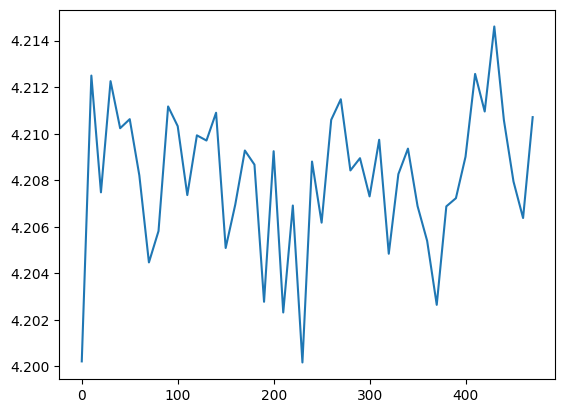

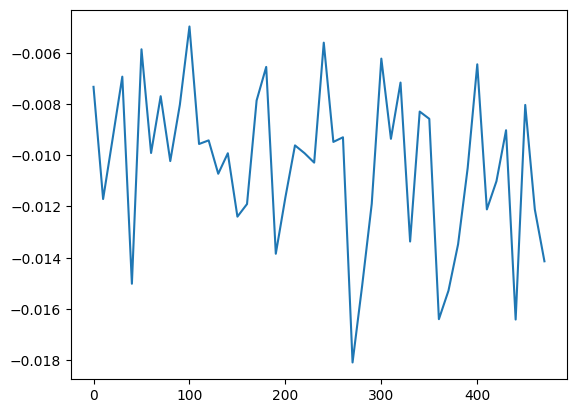

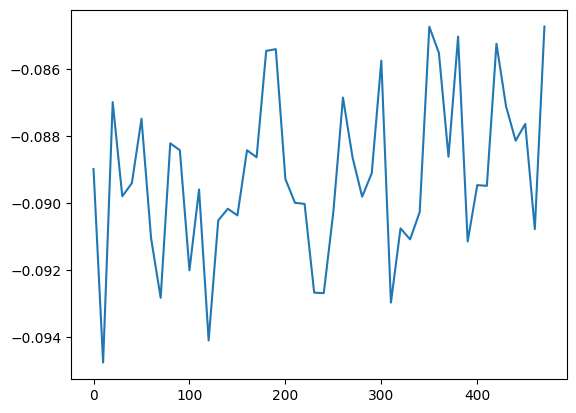

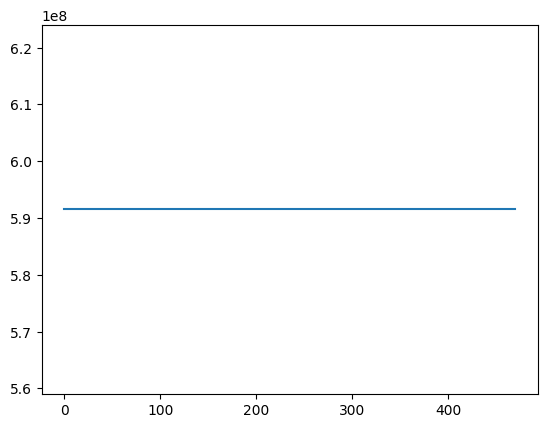

In [6]:
import matplotlib.pyplot as plt

x = np.linspace(0,470,48)
for k in scores.keys():
    plt.plot(x, scores[k])
    plt.show()

In [7]:
print(scores)

{'expressivity': [4.200213496501629, 4.212498298058143, 4.207479513608492, 4.212258256398714, 4.210235696572524, 4.210625465099628, 4.20820768062885, 4.204467424979577, 4.205816021332374, 4.2111713244364815, 4.210324507493239, 4.207362835223858, 4.209929447907668, 4.209706856654241, 4.2109011228267965, 4.20508796435136, 4.206954176609333, 4.209277813251202, 4.208670551960285, 4.202775854330796, 4.209247561601492, 4.202315798172584, 4.206913572091323, 4.200166995708759, 4.2088028100820685, 4.2061770879305325, 4.210595662777241, 4.211480461634123, 4.208421193636381, 4.208947777748108, 4.207304862829355, 4.209739492489741, 4.204840091558603, 4.208262205123901, 4.209358939757714, 4.206890197900625, 4.205393561950097, 4.20264456822322, 4.2068765713618355, 4.20722902738131, 4.209009867448073, 4.212570337148813, 4.2109534740448, 4.2146086142613335, 4.210584429594187, 4.207945181773259, 4.206375342149001, 4.210712304482093], 'info_flow': [-0.007331371307373047, -0.011709213256835938, -0.009337